---
title: "Buy vs. Rent, A Financial Modeling Workflow in Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2022-8-6"
description: "Using `numpy-financial` and monte-carlo simulation to evaluate investments."
draft: false
categories:  ['Python', 'Probability']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

## Summary
This post goes through the following exercises:  

- Use `numpy-financial` to build a [loan amortization calculator](https://en.wikipedia.org/wiki/Amortization_calculator) for a home mortgage  
- Use said table as well as simulated home and stock equity returns over time to compare year-to-year wealth resulting from the following strategies:  
  1.  buying a residential living space  
  2. renting one instead and investing the dollar amount that would have been your down-payment

### A Note on `numpy-financial`
At one point in time, `numpy`, the popular Python numerical analysis library, included 10 specialized functions for financial analysis. Given their specific nature, they were eventually removed from `numpy`, I think in 2019 ([learn about why that is here](https://numpy.org/neps/nep-0032-remove-financial-functions.html)) and are now available in the separate library, `numpy-financial`. The library still seems focused on the same [10 core functions](https://numpy.org/numpy-financial/latest/), which handle tasks like calculating loan payment amounts given some inputs, and applied financial economics tasks like calculating time value of money. Cool... Anyways, I'll use it to create an amortization schedule for a mortgage.



### Environment/Packages
I built this notebook in a Google Colab instance, which seems to include most major Python libraries ([more info](https://stackoverflow.com/questions/47109539/what-are-the-available-libraries-within-google-colaboratory)).  

You'll probably have to download `numpy-financial` (it's not included in Anaconda as far as I know), which you can accomplish within any notebook-like environment using the following command:


In [21]:
! pip install numpy-financial

^C


You'll want to load the usual suspects - `pandas`, `numpy`, `seaborn`, `matplotlib`. I also run `from datetime import datetime` since we will be working with ranges of dates, and I run `sns.set_style()` to get my seaborn plots looking a bit more aesthetically pleasing - read more on themes [here](https://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme).  


In [ ]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Problem Setup
### Definining Constants
I'll run this as a comparison between buying an apartment that costs $<b></b>700,000 with a 20% downpayment, versus renting a home for \$2,600 a month. This is meant to approximate buying versus renting a two-bed one-bath apartment.  

Buying fees are defined at 4%, the homeowners association fees are defined as \$700 monthly.


In [ ]:
# Buying Constants
interest_rate = 0.065
cost = 700000
hoa = 700
down_payment = cost * .2
principal = cost - down_payment
buying_fees = principal*.04

# Renting Constants
rent = 2600

`npf.pmt()` can be used to generate a monthly mortgage payment given those buying constants:


In [ ]:
npf.pmt(interest_rate/12, 12*30, principal)

-3539.580931560606

alternatively, we can use `npf.ppt()` to see how much of the payment goes towards the principal, and use `npf.ipmt()` to see how much goes towards interest (see below for applications of those functions).

### Defining Random Variables
I'll make the simplifying assumption that both "annual home appreciation" and "annual stock appreciation" are generated from normal distributions. This is a kind of strong assumption, but one that seems to be routinely made at least with regards to stock market returns, even if there might be better distribution choices out there ([more here](https://arxiv.org/ftp/arxiv/papers/1906/1906.10325.pdf)). 

Here's a look at how we'll draw from a normal distribution. Given an average annual return, $\mu = 0.0572$ ($\mu$, or, mu, is a common variable name for average) and a standard deviation $\sigma = 0.1042$ ($\sigma$, or, sigma, is the common variable name for standard deviation), we can draw one sample from a normal distribution as follows:


In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
import yfinance as yf

In [ ]:
# Download S&P 500 data
sp500 = yf.download("AAPL", start="1950-01-01")["Adj Close"].dropna()
sp500 = sp500.dropna()

[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['AAPL']: Exception('AAPL: No price data found, symbol may be delisted (1d 1950-01-01 -> 2025-05-31)')


In [ ]:
from fredapi import Fred
import os
fred = Fred(api_key=os.environ.get('fred_api'))

In [ ]:
sf_home = fred.get_series('SFXRSA')
sf_home = sf_home.dropna()

<AxesSubplot: >

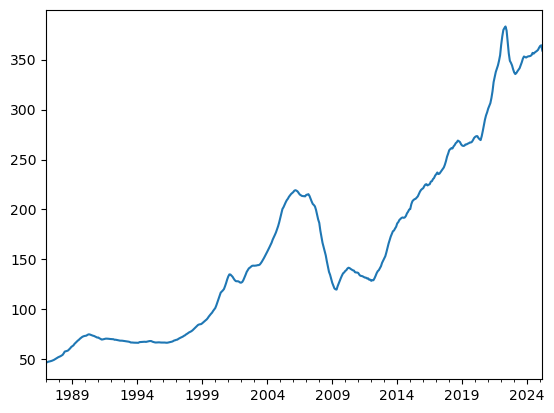

In [17]:
sf_home.plot()

<AxesSubplot: >

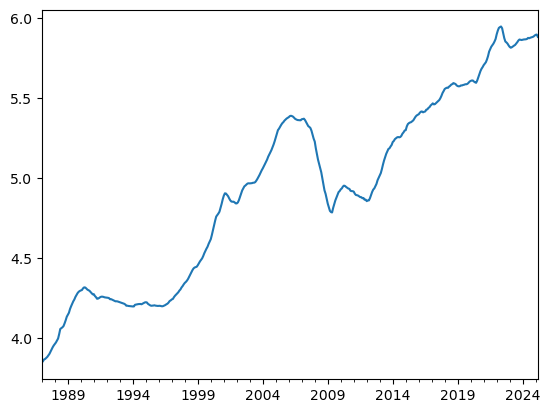

In [80]:
log_prices = np.log(sf_home)
log_prices.plot()

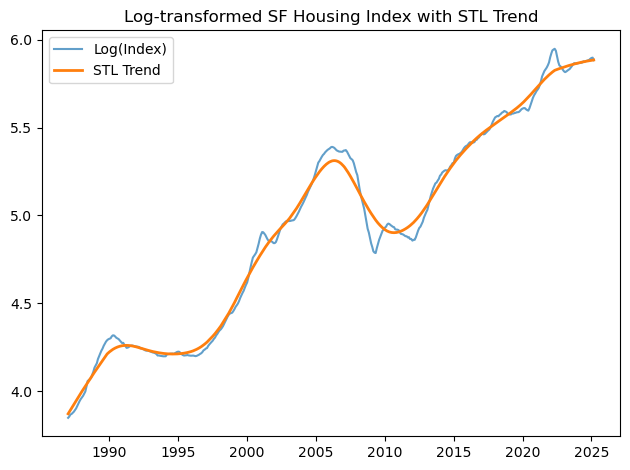

In [81]:
from statsmodels.tsa.seasonal import STL
# -- STL DECOMPOSITION --
stl = STL(log_prices, period=36)
res = stl.fit()
trend = res.trend
resid = res.resid

# === 1. Plot log prices with trend ===
plt.figure()
plt.plot(log_prices, label='Log(Index)', alpha=0.7)
plt.plot(trend, label='STL Trend', linewidth=2)
plt.title('Log-transformed SF Housing Index with STL Trend')
plt.legend()
plt.tight_layout()
plt.show()

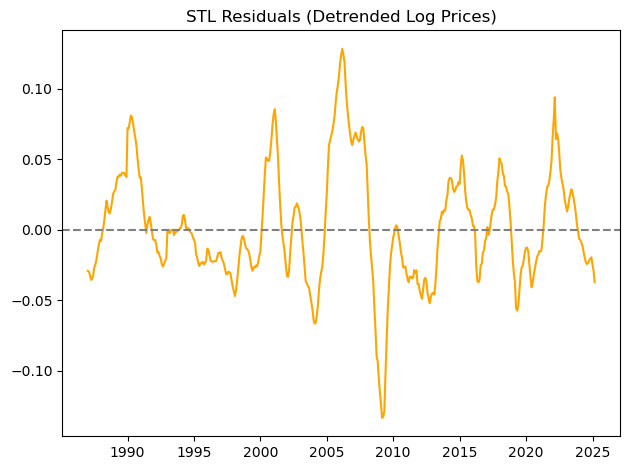

In [82]:
# === 2. Residual diagnostics ===
plt.figure()
plt.plot(resid, label='STL Residuals', color='orange')
plt.axhline(0, linestyle='--', color='gray')
plt.title('STL Residuals (Detrended Log Prices)')
plt.tight_layout()
plt.show()

In [83]:
from sklearn.linear_model import LinearRegression
from datetime import timedelta
future_months = 120
block_size = 12
n_simulations = 100
N_years = 10

In [84]:
# === 3. Fit linear model to trend (last N years) ===
trend_recent = trend.last(f'{N_years}Y')
X = np.arange(len(trend_recent)).reshape(-1, 1)
y = trend_recent.values
model = LinearRegression().fit(X, y)
X_future = np.arange(len(X), len(X) + future_months).reshape(-1, 1)
trend_forecast = model.predict(X_future)

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_66512\1996583068.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  trend_recent = trend.last(f'{N_years}Y')
C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_66512\1996583068.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  trend_recent = trend.last(f'{N_years}Y')


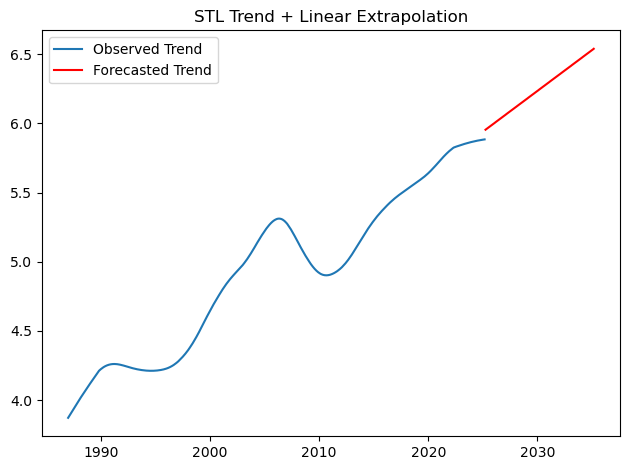

In [85]:
# Plot extrapolated trend
plt.figure()
plt.plot(trend, label='Observed Trend')
plt.plot(
    pd.date_range(trend.index[-1] + timedelta(days=30), periods=future_months, freq='MS'),
    trend_forecast,
    color='red', label='Forecasted Trend'
)
plt.title('STL Trend + Linear Extrapolation')
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
# === 4. Show example of block bootstrapped residuals ===
def block_bootstrap(residuals, n_periods, block_size=4):
    blocks = []
    n_blocks = int(np.ceil(n_periods / block_size))
    for _ in range(n_blocks):
        start = np.random.randint(0, len(residuals) - block_size)
        blocks.extend(residuals[start:start + block_size])
    return np.array(blocks[:n_periods])

sample_boot = block_bootstrap(resid.dropna(), future_months, block_size)

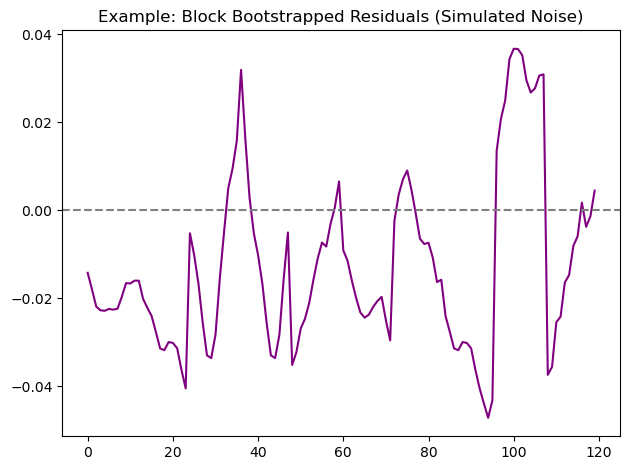

In [98]:
plt.figure()
plt.plot(sample_boot, color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Example: Block Bootstrapped Residuals (Simulated Noise)')
plt.tight_layout()
plt.show()

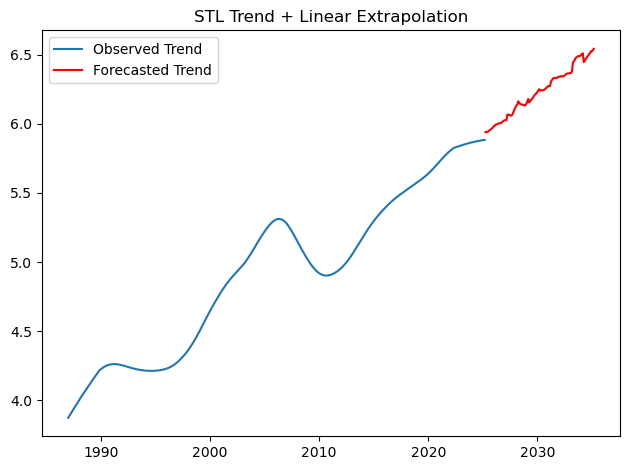

In [99]:
# Plot extrapolated trend
plt.figure()
plt.plot(trend, label='Observed Trend')
plt.plot(
    pd.date_range(trend.index[-1] + timedelta(days=30), periods=future_months, freq='MS'),
    (trend_forecast + sample_boot),
    color='red', label='Forecasted Trend'
)
plt.title('STL Trend + Linear Extrapolation')
plt.legend()
plt.tight_layout()
plt.show()

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                  458
Model:               MarkovRegression   Log Likelihood                1485.238
Date:                Sat, 31 May 2025   AIC                          -2958.477
Time:                        12:27:11   BIC                          -2933.715
Sample:                             0   HQIC                         -2948.724
                                - 458                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.472      0.141      -0.000       0.002
sigma2      2.722e-05   3.31e-06      8.213      0.0

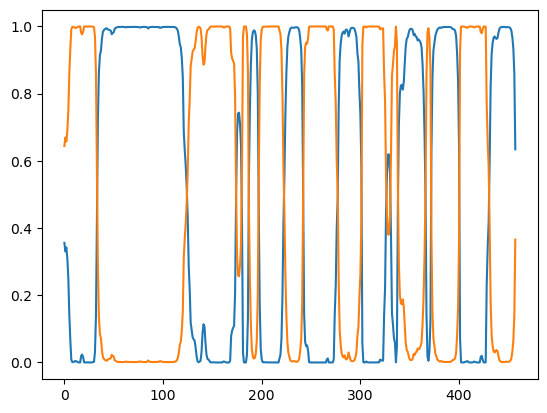

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Step 1: Convert log prices to returns
 # insert your data here
returns = np.diff(log_prices)  # log returns

# Step 2: Fit Markov Switching model (e.g., 2 regimes, AR(1) in each)
model = MarkovRegression(returns, k_regimes=2, trend='c', switching_variance=True)
result = model.fit()

# Step 3: Summary and regime probabilities
print(result.summary())

# Smoothed regime probabilities
smoothed_probs = result.smoothed_marginal_probabilities
plt.plot(smoothed_probs)
plt.show()


C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_66512\2205870326.py:15: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  trend_recent = trend_train.last('10Y')
C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_66512\2205870326.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  trend_recent = trend_train.last('10Y')


📊 STL + Bootstrap Forecast Performance
R²:   -22.5005
RMSE: 1.1821
MAE:  1.0954

📊 Normal Sim Forecast Performance
R²:   -1.2241
RMSE: 0.3636
MAE:  0.3324



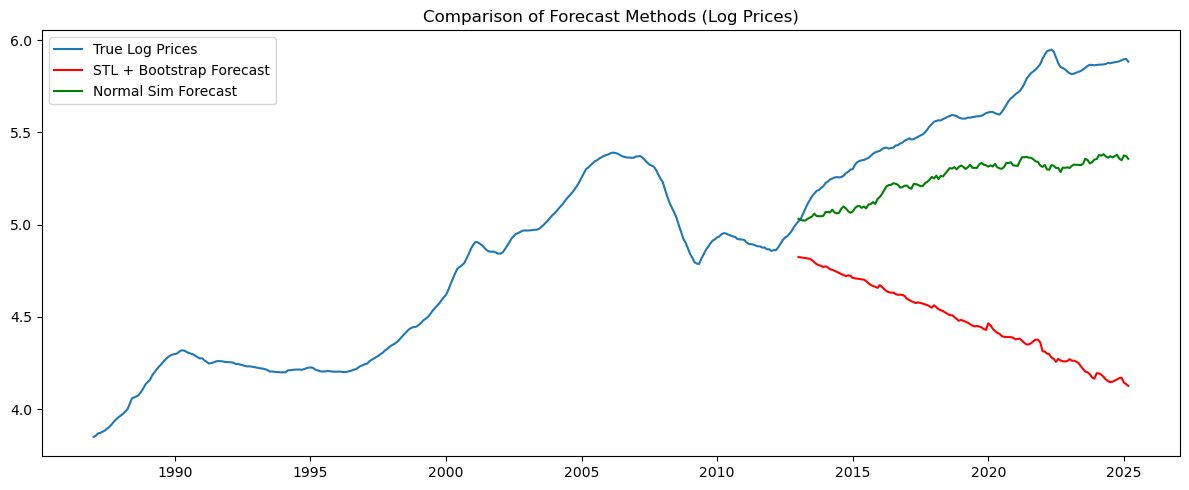

In [71]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Define split point
split_date = '2013-01-01'
log_prices_train = log_prices[:split_date]
log_prices_test = log_prices[split_date:]
n_test = len(log_prices_test)

# 2. STL on training data
stl_train = STL(log_prices_train, period=12).fit()
trend_train = stl_train.trend
resid_train = stl_train.resid.dropna()

# Extrapolate trend linearly from last N years of training trend
trend_recent = trend_train.last('10Y')
X = np.arange(len(trend_recent)).reshape(-1, 1)
y = trend_recent.values
model = LinearRegression().fit(X, y)
X_future = np.arange(len(X), len(X) + n_test).reshape(-1, 1)
trend_forecast = model.predict(X_future)

# Bootstrap residuals and add to trend forecast
sim_resid_stl = block_bootstrap(resid_train, n_test, block_size)
sim_log_stl = trend_forecast + sim_resid_stl
sim_prices_stl = np.exp(sim_log_stl)

# 3. Fit normal distribution to training log returns
log_returns_train = log_prices_train.diff().dropna()
mu, sigma = log_returns_train.mean(), log_returns_train.std()

# Simulate log returns and add to final value of training log prices
sim_log_returns_normal = np.random.normal(mu, sigma, size=n_test)
sim_log_normal = [log_prices_train.iloc[-1]]
for r in sim_log_returns_normal:
    sim_log_normal.append(sim_log_normal[-1] + r)
sim_log_normal = sim_log_normal[1:]
sim_prices_normal = np.exp(sim_log_normal)

# 4. True test log prices
true_log_prices = log_prices_test[:n_test]

# 5. Evaluation metrics
def evaluate(pred, truth, label):
    r2 = r2_score(truth, pred)
    rmse = mean_squared_error(truth, pred, squared=False)
    mae = mean_absolute_error(truth, pred)
    print(f"📊 {label} Forecast Performance")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}\n")

evaluate(sim_log_stl, true_log_prices, "STL + Bootstrap")
evaluate(sim_log_normal, true_log_prices, "Normal Sim")

# 6. Plot for visual comparison
plt.figure(figsize=(12, 5))
plt.plot(log_prices, label='True Log Prices')
plt.plot(log_prices_test.index, sim_log_stl, label='STL + Bootstrap Forecast', color='red')
plt.plot(log_prices_test.index, sim_log_normal, label='Normal Sim Forecast', color='green')
plt.title('Comparison of Forecast Methods (Log Prices)')
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\peteramerkhanian\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


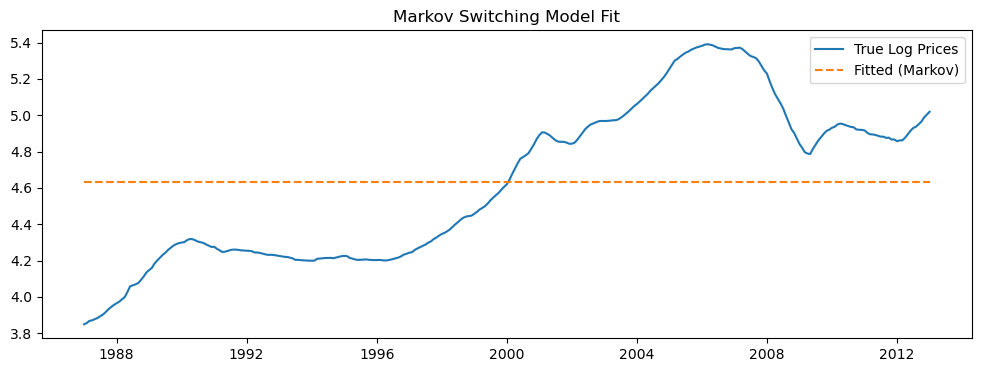

<AxesSubplot: title={'center': 'Probability of Regime 0 (e.g. Boom)'}>

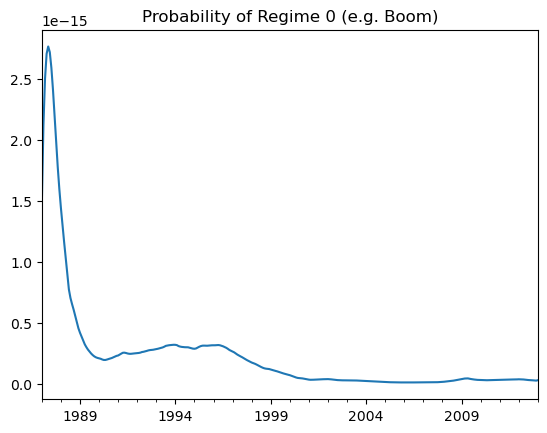

In [75]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Markov switching model with 2 regimes: mean & variance change
model = MarkovRegression(log_prices_train, k_regimes=2, trend='c', switching_variance=False)
res = model.fit()

# Forecast future values (in-sample first)
fitted = res.fittedvalues

# Plot in-sample fit
plt.figure(figsize=(12, 4))
plt.plot(log_prices_train, label='True Log Prices')
plt.plot(fitted, label='Fitted (Markov)', linestyle='--')
plt.title("Markov Switching Model Fit")
plt.legend()
plt.show()

# Show smoothed regime probabilities
res.smoothed_marginal_probabilities[0].plot(title="Probability of Regime 0 (e.g. Boom)")


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
import os


# Initialize FRED API (you need to get your own API key from https://fred.stlouisfed.org/)
fred = Fred(api_key=os.environ.get('fred_api'))

# Download S&P 500 data
sp500 = yf.download('^GSPC', start='2000-01-01', interval='1mo')['Adj Close']
sp500 = sp500.dropna()

# Download San Francisco Home Price Index data
sf_home = fred.get_series('SFXRSA')
sf_home = sf_home.dropna()

# Align dates
data = pd.DataFrame({'SP500': sp500, 'SF_Home': sf_home})
data = data.dropna()

# Calculate monthly returns
returns = data.pct_change().dropna()


In [36]:
# Set a random seed for stability of results
np.random.seed(10)

mean = .0572
standard_deviation = .1042
samples = 1

# Draw the sample
np.random.normal(mean, standard_deviation, samples)

array([0.19595131])

We now simulate market returns for every month by supplying mean and standard deviation values for both home and stock market appreciation and drawing 360 samples (360 months in 30 years). For simplicity, we'll just use world-wide aggregate values from ["The Rate of Return on Everything, 1870-2015"](https://www.frbsf.org/economic-research/wp-content/uploads/sites/4/wp2017-25.pdf).


In [25]:
mu_stock = .1081
sigma_stock = .2267

mu_home = .0572
sigma_home = .1042

Given that stock and home appreciation is probably correlated, I'll have ti sample from a bivariate normal distribution using `numpy.random.Generator.multivariate_normal` - documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html), rather than the univariate distribution draw shown above. I am going to assume a correlation coefficient, $\rho_{stock,home}$ of 0.5 - a fairly clear correlation.  
In order to use that numpy function, I'll need to translate my correlation statistic into a covariance statistic, and I'll use the following formula ([source](https://en.wikipedia.org/wiki/Correlation)):  
$$ \begin{align*}
cov_{stock,home} &= \rho_{stock,home} \times \sigma_{stock} \sigma_{home} \\\
cov_{stock,home} &= 0.5 \times .2267 \times .1042 \end{align*}
$$

I calculate covariance and confirm that the covariance and correlations match up below:


In [26]:
cov = 0.5 * sigma_stock * sigma_home
print("Covariance:", cov)
print("Back to correlation:", cov / (sigma_stock * sigma_home))

Covariance: 0.01181107
Back to correlation: 0.5


Now that I have the covariance, I'll be able to sample from a bivariate normal distribution of the form shown below ([source](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2)).    
$$
\begin{pmatrix} Stock \\\\ Home\end{pmatrix} \sim \mathcal{N} \left[ \begin{pmatrix} \mu_{s} \\\ \mu_{h}\end{pmatrix}, \begin{pmatrix} \sigma_{s}^2 & cov_{s,h} \\\ cov_{s,h} & \sigma_{h}^2\end{pmatrix} \right]
$$  

*Note, $s$ is shorthand for stock and $h$ is shorthand for home.*  
  
Now I'll code that in Python and confirm that the means and standard deviations of our samples match what we expect:


In [27]:
cov_matrix = np.array([[sigma_stock**2, cov],
              [cov, sigma_home**2]])

returns_df = pd.DataFrame(np.random
                          .default_rng(30)
                          .multivariate_normal([mu_stock, mu_home],
                                               cov_matrix,
                                               360),
                          columns=["Stock_Appreciation", "Home_Appreciation"])
print("Means:", returns_df.mean(axis=0).values)
print("Std. Devs:", returns_df.std(axis=0).values)

returns_df = (returns_df / 12)

Means: [0.10764063 0.05970695]
Std. Devs: [0.22544095 0.10543034]


Plotting the simulated values, we can see that stock market returns are typically higher than home value appreciation.


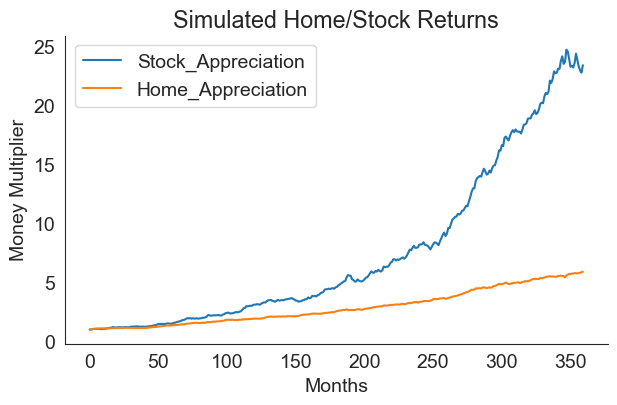

In [9]:
returns_df.add(1).cumprod().plot(figsize=(7,4))
plt.xlabel("Months")
plt.ylabel("Money Multiplier")
plt.title("Simulated Home/Stock Returns")
sns.despine();

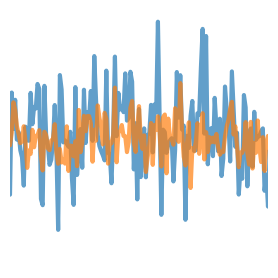

In [10]:
#| output: false
#| echo: false
fig, ax = plt.subplots(figsize=(3, 3))
returns_df.plot(ax=ax, legend=False, linewidth=3, alpha=.7)
ax.set_axis_off()
fig.tight_layout()
ax.set(xlim=(0, 150))
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)


In [11]:
home_performance = returns_df.add(1).cumprod()['Home_Appreciation']
stock_performance = returns_df.add(1).cumprod()['Stock_Appreciation']

Now we can define two spread-sheet-like dataframes:
- one that shows a mortgage amortization schedule for if you were to buy the \$600,000 home, along with the home's appreciation over time.
- one that shows a table of rent payments and the stock market growth of what would have been your down payment (you can invest the down payment since you didn't end up purchasing a house).  

## Scenarios  

### Ownership Table


In [12]:
# Buying Table
df_own = pd.DataFrame()
df_own["Period"] =  pd.Series(range(12*30)) + 1
df_own["Date"] = pd.date_range(start=datetime.today(),
                           periods=12*30,
                           freq='MS',
                           name="Date")
df_own["Principal_Paid"] = npf.ppmt(interest_rate/12,
                                    df_own["Period"],
                                    12*30,
                                    principal)
df_own["Interest_Paid"] = npf.ipmt(interest_rate/12,
                                   df_own["Period"],
                                   12*30,
                                   principal)
df_own["HOA_Paid"] = hoa
df_own["HOA_Paid"] = df_own["HOA_Paid"].cumsum()
df_own["Balance_Remaining"] = principal + df_own["Principal_Paid"].cumsum()
df_own["Home_Value"] = round(cost * home_performance, 2)
df_own["PropTax_Paid"] = (df_own["Period"]
                          .apply(lambda x:
                                 (cost * 1.02**((x-1)/12) * 0.01)
                                 if (x-1) in list(range(0, 12*1000, 12))
                                 else 0)
                          .cumsum())
df_own["Sale_Fees"] = df_own["Home_Value"] * .07
df_own["Own_Profit"] = (df_own["Home_Value"] -
                              df_own["HOA_Paid"] -
                              df_own["Balance_Remaining"] -
                              (buying_fees + df_own["Sale_Fees"]) -
                              df_own["PropTax_Paid"])
df_own = round(df_own, 2)

Note this code, which is a bit of a monster:

In [13]:
df_own["PropTax_Paid"] = (df_own["Period"]
                          .apply(lambda x:
                                 (cost * 1.02**((x-1)/12) * 0.01)
                                 if (x-1) in list(range(0, 12*1000, 12))
                                 else 0)
                          .cumsum())

What is happening here is a calculation of property assessed value and property tax according to California's property assessment/tax regime ([more here)](https://www.boe.ca.gov/proptaxes/pdf/pub29.pdf). We'll look at this in two pieces, first, assessed value. In California, once you purchase a property, its assessed value is set at the purchase price, then increases annually by the lower of 2% or the rate of inflation according to the California Consumer Price Index (CCPI). You could write out an equation for this as follows:  

$$
\begin{align*}
AnnualFactor_y =
\begin{cases}
        1 + CCPI_y, & \text{if } CCPI_y < 0.02 \\\
        1.02, & \text{otherwise}
\end{cases}
\end{align*}
$$

$AnnualFactor$ is the amount that the assessed value of a home will appreciate (expressed as a multiplier) in a given year, $y$. We define $y^*$ as the year of initial purchase and 
$PurchasePrice$ as the amount that the home was purchased for. Given that, $AssessedValue$ is defined as follows:

$$ \begin{align*}
AssessedValue_y =
    \begin{cases}
        PurchasePrice, & \text{if } y = y^* \\
        AssessedValue_{y-1} \times AnnualFactor_y, & \text{otherwise }
    \end{cases}
\end{align*}
$$

In our code, we will simplify this calculation by excluding the CCPI and just always using 1.02 as our annual factor. Therefore, we get:

$$
  AssessedValue_y = PurchasePrice \times 1.02^y
$$

and once we factor in taxes (1%), we get:  

$$
  PropertyTax_y = 0.01(PurchasePrice \times 1.02^y)
$$

and finally we look at the the cumulative total property tax you've paid in a given year $y$, which is `df_own["PropTax_Paid"] `:  

$$
\begin{equation*}
  PropertyTaxPaid_y = \sum_{y=1}^{30} 0.01(PurchasePrice \times 1.02^y)
\end{equation*}
$$

There's some elements added to the code to work between years and months, but that equation is the gist of it.  
We end up with the following table for property ownership:


In [14]:
df_own

,Period,Date,Principal_Paid,Interest_Paid,HOA_Paid,Balance_Remaining,Home_Value,PropTax_Paid,Sale_Fees,Own_Profit
0,1,2025-06-01 08:48:43.587964,-506.25,-3033.33,700,559493.75,701405.73,7000.000000,49098.40,62713.58
1,2,2025-07-01 08:48:43.587964,-508.99,-3030.59,1400,558984.76,707155.41,7000.000000,49500.88,67869.77
2,3,2025-08-01 08:48:43.587964,-511.75,-3027.83,2100,558473.02,723324.03,7000.000000,50632.68,82718.33
3,4,2025-09-01 08:48:43.587964,-514.52,-3025.06,2800,557958.50,737245.96,7000.000000,51607.22,95480.25
4,5,2025-10-01 08:48:43.587964,-517.31,-3022.28,3500,557441.19,745606.08,7000.000000,52192.43,103072.46
...,...,...,...,...,...,...,...,...,...,...
355,356,2055-01-01 08:48:43.587964,-3445.26,-94.33,249200,13968.65,4026844.31,283976.554436,281879.10,3175420.00
356,357,2055-02-01 08:48:43.587964,-3463.92,-75.66,249900,10504.74,4044808.10,283976.554436,283136.57,3194890.24
357,358,2055-03-01 08:48:43.587964,-3482.68,-56.90,250600,7022.06,4066823.89,283976.554436,284677.67,3218147.61
358,359,2055-04-01 08:48:43.587964,-3501.54,-38.04,251300,3520.51,4096809.97,283976.554436,286776.70,3248836.21


### Rental Table
This one is a but more simple, only examining the total rent you've paid in a given month and simulated stock returns at that point.


In [15]:
# Rental Table
df_rent = pd.DataFrame()
df_rent["Period"] =  pd.Series(range(12*30)) + 1
df_rent["Date"] = pd.date_range(start=datetime.today(),
                           periods=12*30,
                           freq='MS',
                           name="Date")
df_rent["DownPayment_Invested"] =  stock_performance * down_payment
df_rent["Rent_Paid"] = rent * 1.02**(df_rent["Period"].add(1) % 12 == 0).cumsum()
monthly_savings = df_own[["Principal_Paid", "Interest_Paid"]].sum(axis=1).multiply(-1).add(hoa) - df_rent["Rent_Paid"]
df_rent["Total_Rent_Paid"] = df_rent["Rent_Paid"].cumsum()
df_rent["Rent_Profit"] = df_rent["DownPayment_Invested"] - df_rent["Total_Rent_Paid"] + monthly_savings.cumsum()
df_rent = round(df_rent, 2)

## Results
At this point, I'll merge the ownership and rental tables and plot out what happened in this simulation


In [16]:
merged = pd.merge(df_own, df_rent, on="Period")
merged = merged.melt(value_vars = ["Rent_Profit", "Own_Profit"], id_vars='Period')

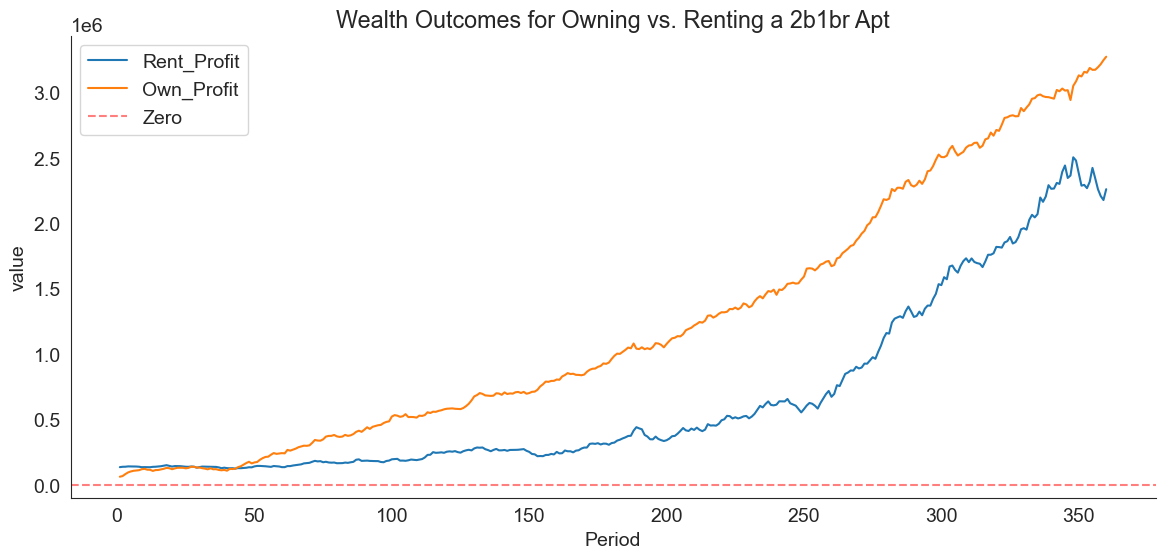

In [37]:
plt.figure(figsize=(14, 6))
plt.title("Wealth Outcomes for Owning vs. Renting a 2b1br Apt")
sns.lineplot(data=merged, x="Period", y="value", hue="variable")
# for x in range(0, 350, 12):
#     if x == 0:
#         plt.axvline(x, color="grey", linestyle=":", alpha=1, label="Year")
#     else:
#         plt.axvline(x, color="grey", linestyle=":", alpha=0.7)
#     plt.text(x+1, -100000, str(int(x/12)), alpha=0.8)
plt.axhline(0, color="red", linestyle="--", alpha=0.5, label="Zero")
plt.legend()
sns.despine()

We can quickly see that ownership will clearly build more wealth in the medium and long run:


In [18]:
years = 5
print(f"Owner after {years} years:", df_own.loc[12*years-1, "Own_Profit"])
print(f"Renter after {years} years:", df_rent.loc[12*years-1, "Rent_Profit"])

Owner after 5 years: 243148.71
Renter after 5 years: 135926.53


However, we can see that, in the unlikely case that the home is sold within the first year or so, the wealth of the renter and the owner are very similar, likely due to the owner contending with buying/selling fees:


In [19]:
years = 1
print(f"Owner after {years} years:", df_own.loc[12*years-1, "Own_Profit"])
print(f"Renter after {years} years:", df_rent.loc[12*years-1, "Rent_Profit"])

Owner after 1 years: 115891.0
Renter after 1 years: 135331.15


A possible takeaway here is that, as long as you can be confident you'll be able to hold onto the house for more than a year, it's probably better to purchase it. Uncertainty estimates would be useful here, and could be obtained by running the simulation under a wide variety of randomly generated market conditions.